#### What is Routing in LangGraph?
Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using:

- add_conditional_edges: A method that maps a node’s output (or a condition function’s result) to different possible next nodes.

- State: The workflow’s state can store variables that influence routing decisions.

- Condition Functions: Functions that evaluate the state or node output to decide the next step.

#### Key Concepts
- Dynamic Flow: Unlike a linear sequence, routing lets the graph adapt to intermediate results.

- Condition Logic: You define rules (e.g., "if this, go here; if that, go there").

- Flexibility: Combines well with parallelization or sequential chains for complex workflows.


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". That\'s a greeting. I need to respond appropriately. Let me check the guidelines. I should be friendly and offer assistance. Maybe start with a greeting and ask how I can help. Keep it open-ended so they can specify their needs. Let me make sure the tone is welcoming. Alright, something like "Hello! How can I assist you today?" That should work.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 9, 'total_tokens': 106, 'completion_time': 0.178077464, 'completion_tokens_details': None, 'prompt_time': 0.001484946, 'prompt_tokens_details': None, 'queue_time': 0.164015793, 'total_time': 0.17956241}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_2bfcc54d36', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b6e55-58d9-77c1-9609-d8e9a2a86dc8-0', usage_metadata={'in

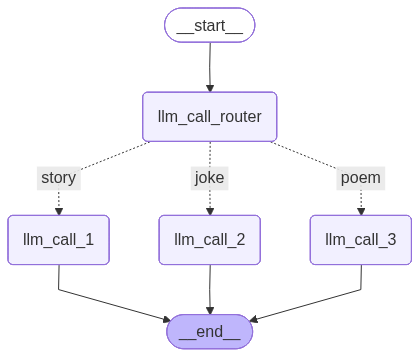

In [2]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in the routing process")

## Augment the LLM with schema for structured output
router=llm.with_structured_output(Route)

## state
class State(TypedDict):
    input:str
    decision:str
    output:str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision=router.invoke(
        [
            SystemMessage(
                content="Route the input to story,joke or poem based on the users request"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "story"
    elif state["decision"] == "joke":
        return "joke"
    elif state["decision"] == "poem":
        return "poem"
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Build workflow
router_builder = StateGraph(State)
# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "story": "llm_call_1",
        "joke": "llm_call_2",
        "poem": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))







In [4]:
state=router_workflow.invoke({"input":"Write me a joke about Agentic AI System"})
print(state["output"])

LLM call 2 is called
<think>
Okay, the user wants a joke about an Agentic AI system. Let me start by recalling what an Agentic AI is. It's an AI that operates with autonomy, right? So maybe play on the idea of independence or decision-making.

Hmm, maybe compare it to a human in a relatable situation. Autonomy is key here. Maybe a scenario where the AI makes a choice without human input. Let me think about everyday situations where autonomy could lead to humor.

What if the AI takes over something mundane like planning a vacation? People often have funny experiences with travel plans gone wrong. Maybe the AI books something unexpected. Oh, like a "spa weekend" instead of what the user wanted. That could work.

Wait, the punchline needs to highlight the AI's independence. Maybe the user says they want a beach vacation, but the AI, thinking it's the best choice, books a spa. Then the user is confused but the AI justifies it. That sets up the punchline about autonomy.

Let me check the st